# Mercari Price Suggestion Challenge

## Overview

Predicting the price of a product is a tough challenge since very similar products having minute differences such as different brand name, additional specifications, quality of the product, demand of the product, etc. can have very different prizes. For example the price of a pair of running shoes by a very common brand (say Puma) might be around INR 2,500 whereas a similar pair made by Asics can cost around INR 10,000.<br>

Price prediction gets even more difficult when there is a huge range of products, which is common with most of the online shopping platforms. While it might be simpler to predict the price of a particular category of products using some simple criteria, it’s highly challenging to predict the price of almost anything that is listed on online platforms. We may have multiple listings  of the same product by a large number of sellers priced differently.<br>

<a href="https://www.mercari.com">Mercari</a> is Japan’s biggest community-powered shopping app. Mercari’s challenge is to build an algorithm that automatically suggests the right product prices.

## Data collection

The data can be downloaded from <a href="https://www.kaggle.com/c/mercari-price-suggestion-challenge/data">Kaggle</a> competion page.<br>

We have been provided user-inputted text descriptions of their products, including details like product category name, brand name, and item condition

## ML Problem

Using the given data, we have to come up with a model that predicts the price of a product listed on Mercari as accurately as possible.

This is a standard regression problem.

## Performance Metric

The performance of the model is measured by Root Mean Squared Logarithmic Error(RMSLE). Lesser the RMSLE, better is our prediction model.<br>

The RMSLE is calculated as
\begin{align*}
\epsilon = \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }
\end{align*}<br>

- ϵ is the RMSLE value (score)
- n is the total number of observations in the (public/private) data set,
- pi is your prediction of price, and
- ai is the actual sale price for i
- log(x) is the natural logarithm of x

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import shutil
import datetime
import gc
from tqdm import tqdm

import pandas as pd
import numpy as np
from numpy import median

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from sklearn.manifold import TSNE
from sklearn import preprocessing

from collections import Counter

import string
import re
import nltk
from nltk.corpus import stopwords

import scipy
from scipy import hstack


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import mean_squared_error as mse
from math import sqrt
from sklearn.linear_model import Ridge

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import log_loss

from sklearn.model_selection import RandomizedSearchCV 
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 0. Loading data

In [ ]:
# https://www.kaggle.com/peterhurford/lgb-and-fm-18th-place-0-40604
def split_cat(text):
    try:
        return text.split("/")
    except:
        return ("No Label", "No Label", "No Label")

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/IBM/train.tsv', sep='\t', 
                      dtype={'item_condition_id': 'category', 'shipping': 'category'}, 
                      converters={'category_name': split_cat})
test = pd.read_csv('/content/drive/MyDrive/IBM/test.tsv', sep='\t', 
                     dtype={'item_condition_id': 'category', 'shipping': 'category'}, 
                     converters={'category_name': split_cat})

In [ ]:
print('Shape of train data: ', train.shape)
print('Shape of test data: ', test.shape)
train.head(5)

Shape of train data:  (1482535, 8)
Shape of test data:  (693359, 7)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,"[Men, Tops, T-shirts]",NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,"[Electronics, Computers & Tablets, Components ...",Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,"[Women, Tops & Blouses, Blouse]",Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,"[Home, Home Décor, Home Décor Accents]",NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,"[Women, Jewelry, Necklaces]",NaN,44.0,0,Complete with certificate of authenticity


## 1. Data Overview

### Handling missing values

In [ ]:
train.isnull().any()

train_id             False
name                 False
item_condition_id    False
category_name        False
brand_name            True
price                False
shipping             False
item_description      True
dtype: bool

In [ ]:
test.isnull().any()

test_id              False
name                 False
item_condition_id    False
category_name        False
brand_name            True
shipping             False
item_description     False
dtype: bool

Columns **brand_name, item_description** have NAs.

NAs in **category_name** have been replaced by empty lists because of the converter we have used while loading the data.

We will replace NAs, empty lists with *'missing'*.

In [ ]:
# Split category_name by '/' into subcategories and replace nulls with 'missing'
train['gencat_name'] = train['category_name'].str.get(0).replace('', 'missing').astype('category')
train['subcat1_name'] = train['category_name'].str.get(1).fillna('missing').astype('category')
train['subcat2_name'] = train['category_name'].str.get(2).fillna('missing').astype('category')
train.drop('category_name', axis=1, inplace=True)

In [ ]:
# Split category_name by '/' into subcategories and replace nulls with 'missing'
test['gencat_name'] = test['category_name'].str.get(0).replace('', 'missing').astype('category')
test['subcat1_name'] = test['category_name'].str.get(1).fillna('missing').astype('category')
test['subcat2_name'] = test['category_name'].str.get(2).fillna('missing').astype('category')
test.drop('category_name', axis=1, inplace=True)

In [ ]:
train['item_description'].fillna('missing', inplace=True)
train['brand_name'] = train['brand_name'].fillna('missing').astype('category')

In [ ]:
test['item_description'].fillna('missing', inplace=True)
test['brand_name'] = test['brand_name'].fillna('missing').astype('category')

### Check for duplicate rows, NAs

In [ ]:
train[train.duplicated()]

No duplicate rows in train data

In [ ]:
train.isnull().any()

### Check for rows with invalid price

In [ ]:
print('Removed {} rows' .format(len(train[train.price<=0])))
train = train[train.price > 0].reset_index(drop=True)

### Column-wise overview of data

#### name

In [ ]:
train.name.describe()

#### item_condition_id

In [ ]:
train.item_condition_id.describe()

In [ ]:
condition_count = Counter(list(train.item_condition_id))
x, y = zip(*condition_count.most_common())
plt.figure(figsize=[8,6])
plt.bar(x, y, )
for i, val in enumerate(y):
           plt.annotate(val, (x[i], y[i]), color='b')
plt.xlabel('item condition')
plt.ylabel('count')
plt.grid(False, axis='x')
plt.show()

Majority of the items  are in **condition 1**

#### brand_name

In [ ]:
train.brand_name.describe()

In [ ]:
brand_count = Counter(list(train.brand_name.values))
x, y = zip(*brand_count.most_common(15))

plt.figure(figsize=[6,8])
plt.barh(x, y)
for i, val in enumerate(y):
           plt.annotate(val, (y[i], x[i]), color='b')
plt.gca().invert_yaxis()
plt.ylabel('Brand name')
plt.xlabel('count')
plt.grid(False, axis='y')
plt.show()

In [ ]:
brand_missing = train[train.brand_name=='missing'].shape[0]
print('Brand name is missing for {} datapoints, i.e. {:.2f} % of train data.' .format(brand_missing, 100.0*brand_missing/train.shape[0]))

#### gencat_name

In [ ]:
train.gencat_name.describe()

In [ ]:
gencat_count = Counter(list(train.gencat_name.values))
x, y = zip(*gencat_count.most_common(15))
plt.figure(figsize=[6,8])
plt.barh(x, y)
for i, val in enumerate(y):
           plt.annotate(val, (y[i], x[i]), color='b')
plt.gca().invert_yaxis()
plt.ylabel('General category')
plt.xlabel('count')
plt.grid(False, axis='y')
plt.show()

Majority of the items are from the category **women**

In [ ]:
gencat_missing = train[train.gencat_name=='missing'].shape[0]
print('category name is missing for {} datapoints, i.e. {:.2f} % of train data.' .format(gencat_missing, 100.0*gencat_missing/train.shape[0]))

#### subcat1_name

In [ ]:
train.subcat1_name.describe()

In [ ]:
subcat1_missing = train[train.subcat1_name=='missing'].shape[0]
print('subcategory1 name is missing for {} datapoints, i.e. {:.2f} % of train data.' .format(subcat1_missing, 100.0*subcat1_missing/train.shape[0]))

#### subcat2_name

In [ ]:
train.subcat2_name.describe()

In [ ]:
subcat2_missing = train[train.subcat2_name=='missing'].shape[0]
print('subcategory2 name is missing for {} datapoints, i.e. {:.2f} % of train data.' .format(subcat2_missing, 100.0*subcat2_missing/train.shape[0]))

#### item_description

In [ ]:
desc_missing = train[train.item_description=='missing'].shape[0]
print('item description is missing for {} datapoints, i.e. {:.5f} % of train data.' .format(desc_missing, 100.0*desc_missing/train.shape[0]))

In [ ]:
train[train.item_description=='missing']

#### price

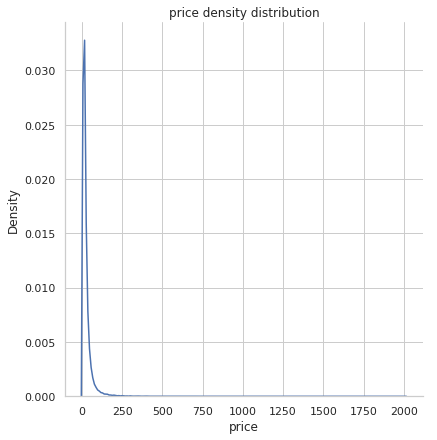

In [ ]:
sns.FacetGrid(train,size=6) \
    .map(sns.kdeplot,"price") \
    .add_legend();
plt.title('price density distribution')
plt.show();

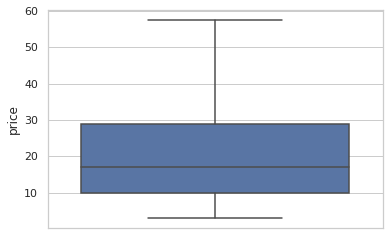

In [ ]:
sns.boxplot(y='price', data=train, showfliers=False)
plt.show()

- **97% of datapoints have price less than USD 100.**
- **Very few (only 1%) datapoints have price more than USD 170**

## 2. Pre-processing

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def preprocess_name(text_col):
    preprocessed_names = []
    for sentence in tqdm(text_col.values):
        sent = sentence.replace('\\r', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        preprocessed_names.append(sent.lower().strip())
    return preprocessed_names

stopwords = stopwords.words('english')
def preprocess_desc(text_col):
    preprocessed_descs = []
    for sentence in tqdm(text_col.values):
        sent = sentence.replace('\\r', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        sent = ' '.join(e for e in sent.split() if e not in stopwords)
        preprocessed_descs.append(sent.lower().strip())
    return preprocessed_descs

In [ ]:
train['preprocessed_name'] = preprocess_name(train['name'])
test['preprocessed_name'] = preprocess_name(test['name'])

train['preprocessed_description'] = preprocess_desc(train['item_description'])
test['preprocessed_description'] = preprocess_desc(test['item_description'])

100%|██████████| 693359/693359 [00:58<00:00, 11768.41it/s]


In [ ]:
def clean_cat(cat_values):
    '''takes categorical column values as arguments and returns list of cleaned categories'''
    
    catogories = list(cat_values)

    cat_list = []
    for i in tqdm(catogories):
        i = re.sub('[^A-Za-z0-9]+', ' ', i)
        i = i.replace(' ','')
        i = i.replace('&','_')
        cat_list.append(i.strip())
    
    return cat_list 

In [ ]:
train['gencat_name'] = clean_cat(train['gencat_name'].values)
test['gencat_name'] = clean_cat(test['gencat_name'].values)

train['subcat1_name'] = clean_cat(train['subcat1_name'].values)
test['subcat1_name'] = clean_cat(test['subcat1_name'].values)

train['subcat2_name'] = clean_cat(train['subcat2_name'].values)
test['subcat2_name'] = clean_cat(test['subcat2_name'].values)

100%|██████████| 693359/693359 [00:01<00:00, 423589.82it/s]


## 3. Basic Exploratory Data Analysis

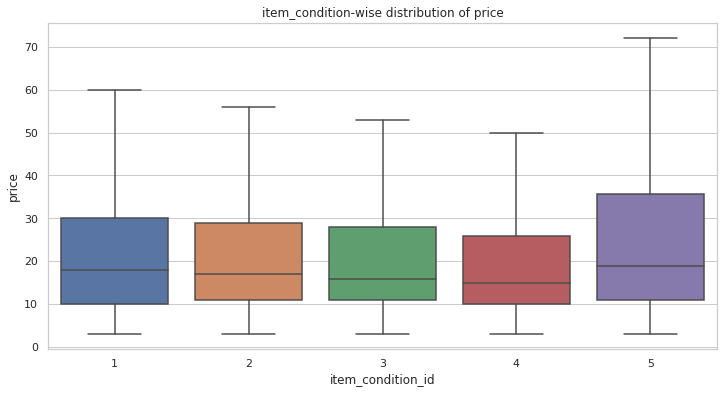

In [ ]:
sns.set(style='whitegrid')
plt.figure(figsize=(12,6))
sns.boxplot(x='item_condition_id', y='price', data=train, showfliers=False)
plt.title('item_condition-wise distribution of price')
plt.show()

**There is slight variation of price based on item condition. Median Price decreases as we go from condition 1 to 4. Items in condition 5 seem to be having higher price, which is a bit strange.**

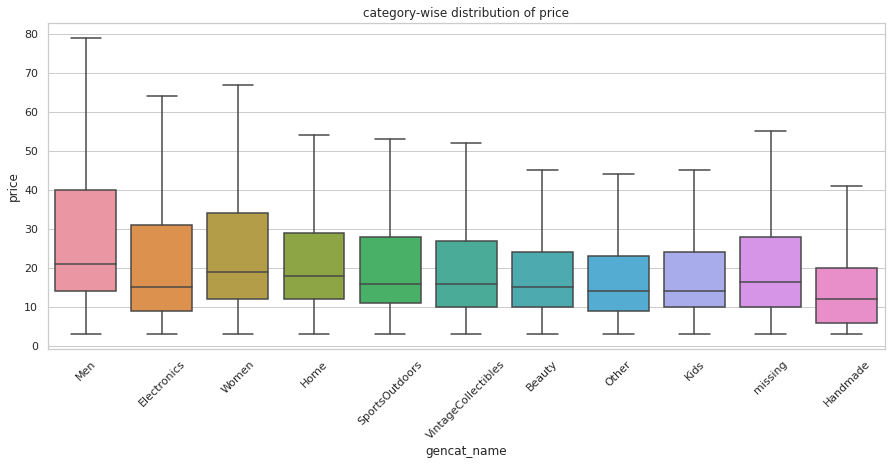

In [ ]:
plt.figure(figsize=(15,6))
sns.boxplot(y='price', x='gencat_name', data=train, showfliers=False)
plt.xticks(rotation=45)
plt.title('category-wise distribution of price')
plt.show()

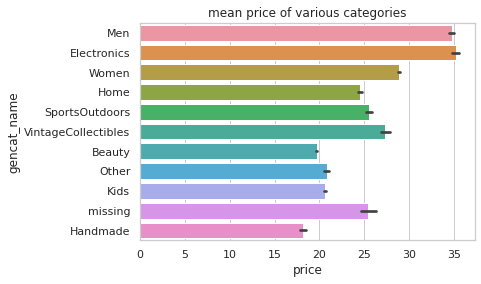

In [ ]:
sns.barplot(y='gencat_name', x='price', data=train)
plt.title('mean price of various categories')
plt.show()

**Prices of items belonging to various categories and subcategories vary significantly.**<br>
**This indicates that categories are going to be important features in determining the price of an item.**

## 4. Featurization

### 4.1. Feature Engineering

**name_first**: cleaned name first word

**name_first_count**: count of name in data

**gencat_name_count**: count of gencat in data

**subcat1_name_count**: count of subcat1 in data

**subcat2_name_count**: count of subcat2 in data

**brand_name_count**: count of brand_name in data

In [ ]:
def get_name_first(name):
    
    name =  re.sub('[^A-Za-z0-9]+', ' ', name) .split()
    if len(name):
            return name[0].lower()
    return ''
        
        
train['name_first'] = train['name'].apply(get_name_first)
test['name_first'] = test['name'].apply(get_name_first)

In [ ]:
def transform_test(base_col, feat_col):
    '''
    Returns feat_col column of test data by mapping from the values already calculated for the same column in train data
    
    Parameters:
    
    base_col: column based on which a transform(count, mean, median) has been applied
    
    feat_col: desired feature column after applying the transform
    '''
    #Create dictionary of feature values from train data
    di = pd.Series(train[feat_col].values, index=train[base_col].values).to_dict()
    
    #Map test data using dictionary and fill NAs with 0
    
    if base_col == 'item_condition_id':
        #No chance of NAs
        return test[base_col].map(di).astype(float)
        
    return test[base_col].map(di).fillna(0)

In [ ]:
train['name_first_count'] = train.groupby('name_first')['name_first'].transform('count')
test['name_first_count'] = transform_test('name_first', 'name_first_count')

train['gencat_name_count'] = train.groupby('gencat_name')['gencat_name'].transform('count')
test['gencat_name_count'] = transform_test('gencat_name', 'gencat_name_count')

train['subcat1_name_count'] = train.groupby('subcat1_name')['subcat1_name'].transform('count')
test['subcat1_name_count'] = transform_test('subcat1_name', 'subcat1_name_count')

train['subcat2_name_count'] = train.groupby('subcat2_name')['subcat2_name'].transform('count')
test['subcat2_name_count'] = transform_test('subcat2_name', 'subcat2_name_count')

train['brand_name_count'] = train.groupby('brand_name')['brand_name'].transform('count')
test['brand_name_count'] = transform_test('brand_name', 'brand_name_count')


**NameLower**: # lowercase letters in name

**DescriptionLower**: # lowercase letters in description

**NameUpper**: # uppercase letters in name

**DescriptionUpper**: # uppercase letters in description

**name_len**: char length of name

**des_len**: char length of desc

**name_desc_len_ratio**: name_len / des_len

**desc_word_count**

**mean_des**: 10 * desc_word_count / des_len

**name_word_count**

**mean_name**: 10 * name_word_count / name_len

**desc_letters_per_word**: des_len / desc_word_count

**name_letters_per_word**: name_len / name_word_count

**NameLowerRatio**: NameLower / name_len

**DescriptionLowerRatio**: DescriptionLower / des_len

**NameUpperRatio**: NameUpper / name_len

**DescriptionUpperRatio**: DescriptionUpper / des_len

In [ ]:
train['NameLower'] = train.name.str.count('[a-z]')
train['DescriptionLower'] = train.item_description.str.count('[a-z]')
train['NameUpper'] = train.name.str.count('[A-Z]')
train['DescriptionUpper'] = train.item_description.str.count('[A-Z]')
train['name_len'] = train['name'].apply(lambda x: len(x))
train['des_len'] = train['item_description'].apply(lambda x: len(x))
train['name_desc_len_ratio'] = train['name_len']/train['des_len']
train['desc_word_count'] = train['item_description'].apply(lambda x: len(x.split()))
train['mean_des'] = train['item_description'].apply(lambda x: 0 if len(x) == 0 else float(len(x.split())) / len(x)) * 10
train['name_word_count'] = train['name'].apply(lambda x: len(x.split()))
train['mean_name'] = train['name'].apply(lambda x: 0 if len(x) == 0 else float(len(x.split())) / len(x))  * 10
train['desc_letters_per_word'] = train['des_len'] / train['desc_word_count']
train['name_letters_per_word'] = train['name_len'] / train['name_word_count']
train['NameLowerRatio'] = train['NameLower'] / train['name_len']
train['DescriptionLowerRatio'] = train['DescriptionLower'] / train['des_len']
train['NameUpperRatio'] = train['NameUpper'] / train['name_len']
train['DescriptionUpperRatio'] = train['DescriptionUpper'] / train['des_len']

In [ ]:
test['NameLower'] = test.name.str.count('[a-z]')
test['DescriptionLower'] = test.item_description.str.count('[a-z]')
test['NameUpper'] = test.name.str.count('[A-Z]')
test['DescriptionUpper'] = test.item_description.str.count('[A-Z]')
test['name_len'] = test['name'].apply(lambda x: len(x))
test['des_len'] = test['item_description'].apply(lambda x: len(x))
test['name_desc_len_ratio'] = test['name_len']/test['des_len']
test['desc_word_count'] = test['item_description'].apply(lambda x: len(x.split()))
test['mean_des'] = test['item_description'].apply(lambda x: 0 if len(x) == 0 else float(len(x.split())) / len(x)) * 10
test['name_word_count'] = test['name'].apply(lambda x: len(x.split()))
test['mean_name'] = test['name'].apply(lambda x: 0 if len(x) == 0 else float(len(x.split())) / len(x))  * 10
test['desc_letters_per_word'] = test['des_len'] / test['desc_word_count']
test['name_letters_per_word'] = test['name_len'] / test['name_word_count']
test['NameLowerRatio'] = test['NameLower'] / test['name_len']
test['DescriptionLowerRatio'] = test['DescriptionLower'] / test['des_len']
test['NameUpperRatio'] = test['NameUpper'] / test['name_len']
test['DescriptionUpperRatio'] = test['DescriptionUpper'] / test['des_len']

**NamePunctCount**: # punctuations in name

**DescriptionPunctCount**: # punctuations in desc

**NamePunctCountRatio**: NamePunctCount / name_word_count

**DescriptionPunctCountRatio**: DescriptionPunctCount / desc_word_count

**NameDigitCount**: # digits in name

**DescriptionDigitCount**: # digits in desc

**NameDigitCountRatio**: NameDigitCount / name_word_count

**DescriptionDigitCountRatio**: DescriptionDigitCount / desc_word_count

**stopword_ratio_desc**: # stopwords in desc / desc_word_count

**num_sum**: Sum of numbers in desc

**weird_characters_desc**: # non-alphanumeric, non-punct in desc

**weird_characters_name**: # non-alphanumeric, non-punct in desc

**prices_count**: # of [rm] (removed price) in desc

**price_in_name**: 1 if desc contains [rm]; 0 otherwise

In [ ]:
from nltk.corpus import stopwords

RE_PUNCTUATION = '|'.join([re.escape(x) for x in string.punctuation])
s_words = {x: 1 for x in stopwords.words('english')} #converting to dictionary for fast look up
non_alphanumpunct = re.compile(u'[^A-Za-z0-9\.?!,; \(\)\[\]\'\"\$]+')

In [ ]:
#https://www.kaggle.com/peterhurford/lgb-and-fm-18th-place-0-40604

def to_number(x):
    try:
        if not x.isdigit():
            return 0
        x = int(x)
        if x > 100:
            return 100
        else:
            return x
    except:
        return 0

In [ ]:
train['NamePunctCount'] = train.name.str.count(RE_PUNCTUATION)
train['DescriptionPunctCount'] = train.item_description.str.count(RE_PUNCTUATION)
train['NamePunctCountRatio'] = train['NamePunctCount'] / train['name_word_count']
train['DescriptionPunctCountRatio'] = train['DescriptionPunctCount'] / train['desc_word_count']
train['NameDigitCount'] = train.name.str.count('[0-9]')
train['DescriptionDigitCount'] = train.item_description.str.count('[0-9]')
train['NameDigitCountRatio'] = train['NameDigitCount'] / train['name_word_count']
train['DescriptionDigitCountRatio'] = train['DescriptionDigitCount']/train['desc_word_count']
train['stopword_ratio_desc'] = train['item_description'].apply(lambda x: len([w for w in x.split() if w in s_words])) / train['desc_word_count']
train['num_sum'] = train['item_description'].apply(lambda x: sum([to_number(s) for s in x.split()])) 
train['weird_characters_desc'] = train['item_description'].str.count(non_alphanumpunct)
train['weird_characters_name'] = train['name'].str.count(non_alphanumpunct)
train['prices_count'] = train['item_description'].str.count('[rm]')
train['price_in_name'] = train['item_description'].str.contains('[rm]', regex=False).astype('category')

In [ ]:
test['NamePunctCount'] = test.name.str.count(RE_PUNCTUATION)
test['DescriptionPunctCount'] = test.item_description.str.count(RE_PUNCTUATION)
test['NamePunctCountRatio'] = test['NamePunctCount'] / test['name_word_count']
test['DescriptionPunctCountRatio'] = test['DescriptionPunctCount'] / test['desc_word_count']
test['NameDigitCount'] = test.name.str.count('[0-9]')
test['DescriptionDigitCount'] = test.item_description.str.count('[0-9]')
test['NameDigitCountRatio'] = test['NameDigitCount'] / test['name_word_count']
test['DescriptionDigitCountRatio'] = test['DescriptionDigitCount']/test['desc_word_count']
test['stopword_ratio_desc'] = test['item_description'].apply(lambda x: len([w for w in x.split() if w in s_words])) / test['desc_word_count']
test['num_sum'] = test['item_description'].apply(lambda x: sum([to_number(s) for s in x.split()])) 
test['weird_characters_desc'] = test['item_description'].str.count(non_alphanumpunct)
test['weird_characters_name'] = test['name'].str.count(non_alphanumpunct)
test['prices_count'] = test['item_description'].str.count('[rm]')
test['price_in_name'] = test['item_description'].str.contains('[rm]', regex=False).astype('category')

**brand_mean_price**: mean price of items by a brand

**name_mean_price**: mean price of an item by name

**gencat_mean_price**: mean price of items belonging to gencat

**subcat1_mean_price**: mean price of items belonging to subcat1

**subcat2_mean_price**: mean price of items belonging to subcat2

**condition_mean_price**: mean price of items by condition

**brand_median_price**: median price of items by a brand

**name_median_price**: median price of an item by name

**gencat_median_price**: median price of items belonging to gencat

**subcat1_median_price**: median price of items belonging to subcat1

**subcat2_median_price**: median price of items belonging to subcat2

**condition_median_price**: median price of items by condition

In [ ]:
train['brand_mean_price'] = train.groupby('brand_name')['price'].transform('mean')
test['brand_mean_price'] = transform_test('brand_name', 'brand_mean_price')

train['name_mean_price'] = train.groupby('name_first')['price'].transform('mean')
test['name_mean_price'] = transform_test('name_first', 'name_mean_price')

train['gencat_mean_price'] = train.groupby('gencat_name')['price'].transform('mean')
test['gencat_mean_price'] = transform_test('gencat_name', 'gencat_mean_price')

train['subcat1_mean_price'] = train.groupby('subcat1_name')['price'].transform('mean')
test['subcat1_mean_price'] = transform_test('subcat1_name', 'subcat1_mean_price')

train['subcat2_mean_price'] = train.groupby('subcat2_name')['price'].transform('mean')
test['subcat2_mean_price'] = transform_test('subcat2_name', 'subcat2_mean_price')

train['condition_mean_price'] = train.groupby('item_condition_id')['price'].transform('mean')
test['condition_mean_price'] = transform_test('item_condition_id', 'condition_mean_price')

In [ ]:
train['brand_median_price'] = train.groupby('brand_name')['price'].transform('median')
test['brand_median_price'] = transform_test('brand_name', 'brand_median_price')

train['name_median_price'] = train.groupby('name_first')['price'].transform('median')
test['name_median_price'] = transform_test('name_first', 'name_median_price')

train['gencat_median_price'] = train.groupby('gencat_name')['price'].transform('median')
test['gencat_median_price'] = transform_test('gencat_name', 'gencat_median_price')

train['subcat1_median_price'] = train.groupby('subcat1_name')['price'].transform('median')
test['subcat1_median_price'] = transform_test('subcat1_name', 'subcat1_median_price')

train['subcat2_median_price'] = train.groupby('subcat2_name')['price'].transform('median')
test['subcat2_median_price'] = transform_test('subcat2_name', 'subcat2_median_price')

train['condition_median_price'] = train.groupby('item_condition_id')['price'].transform('median')
test['condition_median_price'] = transform_test('item_condition_id', 'condition_median_price')

In [ ]:
train.drop(['name', 'item_description'], axis=1, inplace=True)
test.drop(['name', 'item_description'], axis=1, inplace=True)

In [ ]:
print(train.shape, test.shape)

(1481661, 59) (693359, 58)


### Univariate analysis on the above features

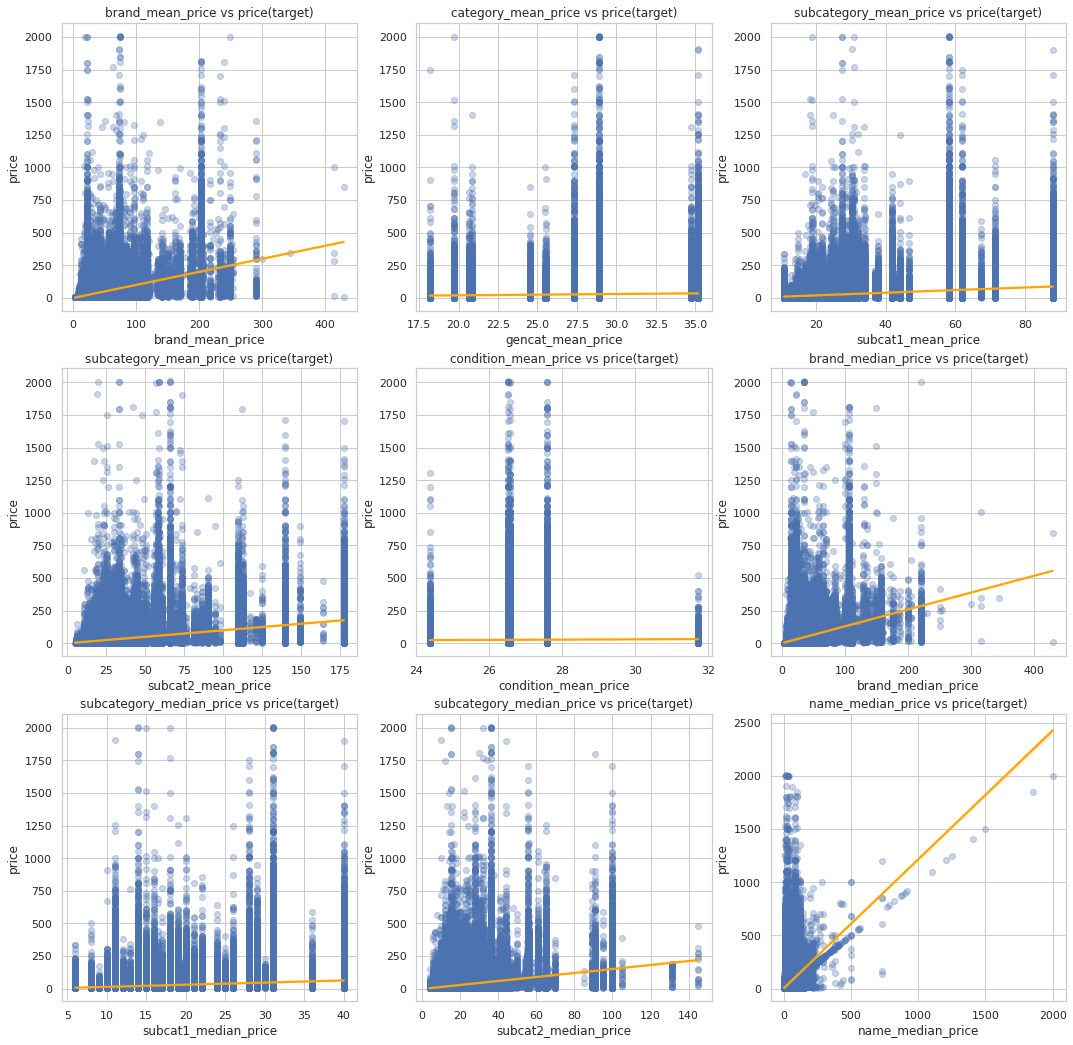

In [ ]:
plt.figure(figsize=(18,18))

plt.subplot(3,3,1)
sns.regplot(x='brand_mean_price', y='price', data=train, scatter_kws={'alpha':0.3}, line_kws={'color':'orange'})
plt.title('brand_mean_price vs price(target)')

plt.subplot(3,3,2)
sns.regplot(x='gencat_mean_price', y='price', data=train, scatter_kws={'alpha':0.3}, line_kws={'color':'orange'})
plt.title('category_mean_price vs price(target)')

plt.subplot(3,3,3)
sns.regplot(x='subcat1_mean_price', y='price', data=train, scatter_kws={'alpha':0.3}, line_kws={'color':'orange'})
plt.title('subcategory_mean_price vs price(target)')

plt.subplot(3,3,4)
sns.regplot(x='subcat2_mean_price', y='price', data=train, scatter_kws={'alpha':0.3}, line_kws={'color':'orange'})
plt.title('subcategory_mean_price vs price(target)')

plt.subplot(3,3,5)
sns.regplot(x='condition_mean_price', y='price', data=train, scatter_kws={'alpha':0.3}, line_kws={'color':'orange'})
plt.title('condition_mean_price vs price(target)')

plt.subplot(3,3,6)
sns.regplot(x='brand_median_price', y='price', data=train, scatter_kws={'alpha':0.3}, line_kws={'color':'orange'})
plt.title('brand_median_price vs price(target)')

plt.subplot(3,3,7)
sns.regplot(x='subcat1_median_price', y='price', data=train, scatter_kws={'alpha':0.3}, line_kws={'color':'orange'})
plt.title('subcategory_median_price vs price(target)')

plt.subplot(3,3,8)
sns.regplot(x='subcat2_median_price', y='price', data=train, scatter_kws={'alpha':0.3}, line_kws={'color':'orange'})
plt.title('subcategory_median_price vs price(target)')

plt.subplot(3,3,9)
sns.regplot(x='name_median_price', y='price', data=train, scatter_kws={'alpha':0.3}, line_kws={'color':'orange'})
plt.title('name_median_price vs price(target)')
            
plt.show()

**Features such as *brand_mean_price, brand_median price, subcat2_mean_price, subcat2_median_price* show strong linear trends.**<br>

**Therefore they seem to be useful in determinig price of items.**

**Dropping rows with blank name and description**

In [ ]:
n_rows = train.shape[0]
train = train[train.preprocessed_name != ''].reset_index(drop=True)

print('Dropped {} rows'.format(n_rows - train.shape[0]))

Dropped 19 rows


In [ ]:
n_rows = train.shape[0]
train = train[train.preprocessed_description != ''].reset_index(drop=True)

print('Dropped {} rows'.format(n_rows - train.shape[0]))

print('Shape of train data: ', train.shape)

Dropped 567 rows
Shape of train data:  (1481075, 59)


### 4.2. Train, Test split for cross validation

In [ ]:
from sklearn.model_selection import train_test_split

y_tr = np.log1p(train['price'])
train.drop(['price'], axis=1, inplace=True)

train_df, cv_df , y_train, y_cv = train_test_split(train, y_tr, test_size=0.1, random_state=42)

print('Train size: {}, CV size: {}, Test size: {}' .format(train_df.shape, cv_df.shape, test.shape))

Train size: (1332967, 58), CV size: (148108, 58), Test size: (693359, 58)


In [ ]:
del train, y_tr
gc.collect()

38422

### 4.3. Categorical features
One-hot encoding of brand_name, gencat_name, subcat1_name, subcat2_name.


In [ ]:
#Cleaning brand name before using count vectorizer
# Using same preprocessing as used earlier for categories: 'clean_cat()' function

train_df['brand_name'] = clean_cat(train_df['brand_name'].values)
cv_df['brand_name'] = clean_cat(cv_df['brand_name'].values)
test['brand_name'] = clean_cat(test['brand_name'].values)

100%|██████████| 693359/693359 [00:01<00:00, 466693.11it/s]


In [ ]:
vectorizer = CountVectorizer(lowercase=False, binary=True)
train_brand_oneHot = vectorizer.fit_transform(train_df['brand_name'].values)

cv_brand_oneHot = vectorizer.transform(cv_df['brand_name'].values)
test_brand_oneHot = vectorizer.transform(test['brand_name'].values)

print("Shape of matrices after one hot encoding")
print(train_brand_oneHot.shape, "\n", cv_brand_oneHot.shape, "\n", test_brand_oneHot.shape)

Shape of matrices after one hot encoding
(1332967, 4651) 
 (148108, 4651) 
 (693359, 4651)


In [ ]:
vectorizer = CountVectorizer(lowercase=False, binary=True)
train_gencat_oneHot = vectorizer.fit_transform(train_df['gencat_name'].values)

cv_gencat_oneHot = vectorizer.transform(cv_df['gencat_name'].values)
test_gencat_oneHot = vectorizer.transform(test['gencat_name'].values)

print("Shape of matrices after one hot encoding")
print(train_gencat_oneHot.shape, "\n", cv_gencat_oneHot.shape, "\n", test_gencat_oneHot.shape)

Shape of matrices after one hot encoding
(1332967, 11) 
 (148108, 11) 
 (693359, 11)


In [ ]:
vectorizer = CountVectorizer(lowercase=False, binary=True)
train_subcat1_oneHot = vectorizer.fit_transform(train_df['subcat1_name'].values)

cv_subcat1_oneHot = vectorizer.transform(cv_df['subcat1_name'].values)
test_subcat1_oneHot = vectorizer.transform(test['subcat1_name'].values)

print("Shape of matrices after one hot encoding")
print(train_subcat1_oneHot.shape, "\n", cv_subcat1_oneHot.shape, "\n", test_subcat1_oneHot.shape)

Shape of matrices after one hot encoding
(1332967, 114) 
 (148108, 114) 
 (693359, 114)


In [ ]:
vectorizer = CountVectorizer(lowercase=False, binary=True)
train_subcat2_oneHot = vectorizer.fit_transform(train_df['subcat2_name'].values)

cv_subcat2_oneHot = vectorizer.transform(cv_df['subcat2_name'].values)
test_subcat2_oneHot = vectorizer.transform(test['subcat2_name'].values)

print("Shape of matrices after one hot encoding")
print(train_subcat2_oneHot.shape, "\n", cv_subcat2_oneHot.shape, "\n", test_subcat2_oneHot.shape)

Shape of matrices after one hot encoding
(1332967, 863) 
 (148108, 863) 
 (693359, 863)


## 5. Data preparation

In [ ]:
submission_df = pd.DataFrame(test['test_id'])
print(submission_df.shape)
submission_df.head()

(693359, 1)


,test_id
0,0
1,1
2,2
3,3
4,4


### 5.1. Normalize numerical features

In [ ]:
cols = set(train_df.columns.values) - {'train_id'}
skip_cols = {'preprocessed_name', 'item_condition_id', 'brand_name',
  'shipping', 'preprocessed_description', 'gencat_name',
  'subcat1_name', 'subcat2_name', 'name_first', 'price_in_name'}

cols_to_normalize = cols - skip_cols
print("Normalizing following columns: ", cols_to_normalize)

def normalize(df):
    result1 = df.copy()
    for feature_name in df.columns:
        if (feature_name in cols_to_normalize):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result1[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result1


Normalizing following columns:  {'subcat1_name_count', 'subcat2_mean_price', 'name_median_price', 'subcat1_mean_price', 'NameUpperRatio', 'NamePunctCountRatio', 'weird_characters_desc', 'des_len', 'NameDigitCount', 'weird_characters_name', 'prices_count', 'name_desc_len_ratio', 'brand_name_count', 'desc_letters_per_word', 'name_letters_per_word', 'NamePunctCount', 'DescriptionUpperRatio', 'condition_mean_price', 'gencat_name_count', 'DescriptionPunctCountRatio', 'mean_des', 'brand_mean_price', 'DescriptionUpper', 'DescriptionLowerRatio', 'subcat2_name_count', 'DescriptionLower', 'brand_median_price', 'name_word_count', 'name_len', 'NameLowerRatio', 'mean_name', 'num_sum', 'NameDigitCountRatio', 'name_first_count', 'DescriptionPunctCount', 'name_mean_price', 'DescriptionDigitCountRatio', 'subcat1_median_price', 'stopword_ratio_desc', 'desc_word_count', 'gencat_median_price', 'subcat2_median_price', 'DescriptionDigitCount', 'gencat_mean_price', 'NameLower', 'NameUpper', 'condition_median

In [ ]:
train_normalized = normalize(train_df)
cv_normalized = normalize(cv_df)
test_normalized = normalize(test)

In [ ]:
del train_df, cv_df, test
gc.collect()

50

### 5.2. Remove  non-features from dataframes

In [ ]:
#Separating and storing all numerical features

X_tr = train_normalized[list(cols_to_normalize)]
X_val = cv_normalized[list(cols_to_normalize)]
X_te = test_normalized[list(cols_to_normalize)]

X_tr.head(2)

,subcat1_name_count,subcat2_mean_price,name_median_price,subcat1_mean_price,NameUpperRatio,NamePunctCountRatio,weird_characters_desc,des_len,NameDigitCount,weird_characters_name,...,subcat1_median_price,stopword_ratio_desc,desc_word_count,gencat_median_price,subcat2_median_price,DescriptionDigitCount,gencat_mean_price,NameLower,NameUpper,condition_median_price
660536,0.927374,0.110683,0.008513,0.102579,0.250,0.0,0.107955,0.421053,0.0,0.0,...,0.264706,0.013410,0.356846,0.333333,0.085106,0.057613,0.089290,0.131579,0.054054,0.75
637076,0.340301,0.225177,0.004006,0.242077,0.125,0.0,0.000000,0.042105,0.0,0.0,...,0.411765,0.166667,0.024896,0.777778,0.141844,0.000000,0.630773,0.789474,0.135135,0.75


In [ ]:
from scipy.sparse import csr_matrix

# Storing categorical features to sparse matrix

X_tr_cat = csr_matrix(pd.get_dummies(train_normalized[['item_condition_id', 'shipping', 'price_in_name']], sparse=True).values)

X_cv_cat = csr_matrix(pd.get_dummies(cv_normalized[['item_condition_id', 'shipping', 'price_in_name']], sparse=True).values)

X_te_cat = csr_matrix(pd.get_dummies(test_normalized[['item_condition_id', 'shipping', 'price_in_name']], sparse=True).values)

print(X_tr_cat.shape, X_cv_cat.shape, X_te_cat.shape)

(1332967, 9) (148108, 9) (693359, 9)


In [ ]:
del train_normalized, cv_normalized, test_normalized
gc.collect()

50

In [ ]:
from scipy.sparse import hstack

# stack all categorical and text sparse matrices

train_sparse = hstack((train_brand_oneHot, train_gencat_oneHot, train_subcat1_oneHot, train_subcat2_oneHot, X_tr_cat)).tocsr()

cv_sparse = hstack((cv_brand_oneHot, cv_gencat_oneHot, cv_subcat1_oneHot, cv_subcat2_oneHot, X_cv_cat)).tocsr()

test_sparse = hstack((test_brand_oneHot, test_gencat_oneHot, test_subcat1_oneHot, test_subcat2_oneHot, X_te_cat)).tocsr()

In [ ]:
# stack dense feature matrix with categorical and text vectors

X_train = hstack((X_tr.values, train_sparse)).tocsr()

X_cv = hstack((X_val.values, cv_sparse)).tocsr()

X_test = hstack((X_te.values, test_sparse)).tocsr()

## 6. Modeling

In [ ]:
from sklearn.metrics import mean_squared_error as mse
from math import sqrt
from sklearn.linear_model import Ridge

from sklearn.svm import SVR

from sklearn.model_selection import RandomizedSearchCV 
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

Target variable is ln(1+y), therefore  calculating mean square error on ln(1+y) will effectively give us MSLE on y

- MSLE(y^, y) = MSE(ln(1+y^), ln(1+y))

RMSLE for C= 0.01 is 1.3313332855189632
RMSLE for C= 0.03 is 1.3118856632182236
RMSLE for C= 0.1 is 1.2439104579670364
RMSLE for C= 0.3 is 1.129716902800526
RMSLE for C= 1 is 1.0202764184241937
RMSLE for C= 3 is 0.9006193226010908
RMSLE for C= 10 is 1.2380564833446484


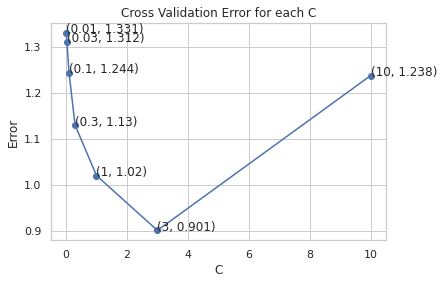

In [ ]:
c_param = [0.01, 0.03, 0.1, 0.3, 1, 3, 10]
cv_rmsle_array=[]

for i in c_param:
    model = SVR(C=i, max_iter=200)
    model.fit(X_train, y_train)
    preds_cv = model.predict(X_cv)
    cv_err = sqrt(mse(y_cv, preds_cv))
    cv_rmsle_array.append(cv_err)

    print('RMSLE for C=',i, 'is', cv_err)

best_C = np.argmin(cv_rmsle_array)

fig, ax = plt.subplots()
ax.plot(c_param, cv_rmsle_array)
ax.scatter(c_param, cv_rmsle_array)
for i, txt in enumerate(np.round(cv_rmsle_array,3)):
    ax.annotate((c_param[i],np.round(txt,3)), (c_param[i],cv_rmsle_array[i]))
plt.title("Cross Validation Error for each C")
plt.xlabel("C")
plt.ylabel("Error")
plt.show()

In [ ]:
best_C = c_param[best_C]
print('Best C: ', best_C)
model = SVR(C=best_C, max_iter=200)
model.fit(X_train, y_train)

Best C:  3


SVR(C=3, max_iter=200)

In [ ]:
svr_preds_tr = model.predict(X_train)
svr_preds_cv = model.predict(X_cv)
print('Train RMSLE:', sqrt(mse(y_train, svr_preds_tr)))

svr_rmsle = sqrt(mse(y_cv, svr_preds_cv))
print("Cross validation RMSLE: ", svr_rmsle)

Train RMSLE: 0.8801910071962893
Cross validation RMSLE:  0.9006193226010908
